In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import pyro.infer.combinators as combinator
import numpy
from torch import Tensor, tensor, distributions, nn

import pyro
import pyro.distributions as dist
import pyro.optim.pytorch_optimizers as optim
from pyro import poutine
from pyro.infer.combinators import (
    compose,
    extend,
    primitive,
    propose,
    with_substitution,
    stl_trick,
    augment_logweight,
    nested_objective,
    _LOSS,
    _RETURN,
)
from pyro.nn import PyroModule, PyroParam
from pyro.poutine import Trace, replay
from pyro.poutine.handlers import _make_handler
from pyro.poutine.messenger import Messenger
from pyro.poutine.trace_messenger import TraceMessenger

import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import math
%matplotlib inline



In [3]:
#plotting code
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.interpolate import interpn
from matplotlib import cm


def plot_sample(
    ax, x, y=None, sort=True, bins=100, range=None, weight_cm=False, **kwargs
):
    ax.tick_params(
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )

    if y is None:
        assert x.shape[-1] == 2
        x, y = x[:,0], x[:,1]

    mz, x_e, y_e = numpy.histogram2d(
        x.numpy(), y.numpy(), bins=bins, density=True, range=range
    )
    if weight_cm:
        z = interpn(
            (0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])),
            mz,
            numpy.vstack([x, y]).T,
            method="splinef2d",
            bounds_error=False,
        )
        z[numpy.where(numpy.isnan(z))] = 0.0  # To be sure to plot all data
        # Sort the points by density, so that the densest points are plotted last
        if sort:
            idx = z.argsort()
            x, y, z = x[idx], y[idx], z[idx]
        cmap = cm.get_cmap("viridis")
        ax.set_facecolor(cmap(0.0))
        ax.scatter(x, y, c=z, cmap=cmap, **kwargs)
        return mz
    else:
        ax.imshow(mz)

In [4]:
def plot_sequence(labels_and_Xs, dpi=100, fontsize=18, *plot_args, **plot_kwargs):
    K = len(labels_and_Xs)
    fig = plt.figure(figsize=(3*K, 3*1), dpi=dpi)
    for k, (label, X) in zip(range(K), labels_and_Xs):
        ax = fig.add_subplot(1, K, k+1)
        ax.set_xlabel(label, fontsize=fontsize)
        plot_sample(ax, X, *plot_args, **plot_kwargs)
    return fig

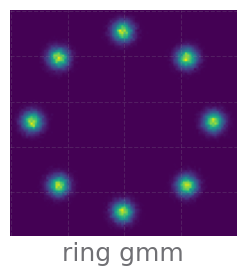

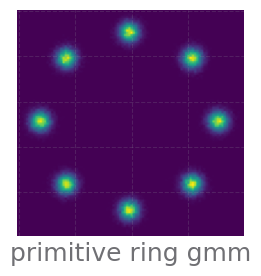

In [5]:
# set up target
from pyro.distributions import TorchDistribution

class GMM(TorchDistribution):
    arg_constraints = {}
    def __init__(self, locs, covs, batch_shape=torch.Size()):
        super().__init__()
        assert len(locs.shape) == 2 and len(covs.shape) == 3
        assert locs.shape[0] == covs.shape[0]
        assert covs.shape[1] == covs.shape[2] and covs.shape[1] == locs.shape[1]

        self.K = locs.shape[0]
        self.locs = locs
        self.covs = covs
        self.components = [
            dist.MultivariateNormal(loc=locs[k], covariance_matrix=covs[k])
            for k in range(self.K)
        ]
        self.cluster_dist = dist.Categorical(torch.ones(self.K))
        self._batch_shape = batch_shape
        self._event_shape = torch.Size([locs.shape[1]])
        self.has_rsample = False

    @property
    def batch_shape(self):
        return self._batch_shape

    @property
    def event_shape(self):
        return self._event_shape

    def sample(self, sample_shape=torch.Size([])):
        locs, covs, K = self.locs, self.covs, self.K
        zs = self.cluster_dist.sample(sample_shape)
        xs = []
        values, _ = torch.sort(zs)

        for k in range(self.K):
            n_k = (values == k).sum()
            if n_k > 0:
                x_k = self.components[k].sample(sample_shape=(n_k, *zs.shape[1:-1]))
                xs.append(x_k)
        xs = torch.cat(xs)
        ix = torch.randperm(xs.shape[0])
        return xs[ix].view(self.event_shape if len(zs.shape) == 0 else xs.shape)

    def log_prob(self, value):
        lds = []
        for i, comp in enumerate(self.components):
            ld_i = comp.log_prob(value)
            lds.append(ld_i)
        lds_ = torch.stack(lds, dim=0)
        ld = torch.logsumexp(lds_, dim=0)
        return ld


class RingGMM(GMM):
    def __init__(self, radius=10, scale=0.5, K=8):
        alpha = 2 * math.pi / K
        angles = alpha * torch.arange(K).float()
        x = radius * torch.sin(angles)
        y = radius * torch.cos(angles)
        locs = torch.stack((x, y), dim=0).T
        covs = torch.stack([torch.eye(2) * scale for m in range(K)], dim=0)
        super().__init__(locs, covs)


num_renderable_samples = 100000
with pyro.plate("samples", num_renderable_samples):
    _ = plot_sequence([("ring gmm", pyro.sample("test", RingGMM()))])

# we actually want this wrapped as a `primitive` program. this looks like:
class RingModel(PyroModule):
    def __init__(self, name, radius=10, scale=0.5, K=8):
        super().__init__()
        self.name, self.radius, self.scale, self.K = name, radius, scale, K
        self.dist = RingGMM(self.radius, self.scale, self.K)

    def forward(self):
        return pyro.sample(self.name, self.dist)

def ring_gmm(name, radius=10, scale=0.5, K=8):
    return primitive(RingModel(name, radius, scale, K))

with pyro.plate("samples", num_renderable_samples):
    _ = plot_sequence([("primitive ring gmm", ring_gmm("p")().nodes['_RETURN']['value'])])

In [6]:
# set up annealing path

class MultivariateNormal(PyroModule):
    def __init__(self, name, loc=torch.zeros(1), cov=torch.ones(1)):
        super().__init__()
        self.name, self.loc, self.cov = name, loc, cov
        self.dist = dist.MultivariateNormal(loc=self.loc, covariance_matrix=self.cov)

    def forward(self):
        return pyro.sample(self.name, self.dist)


def multivariate_normal(name, loc, cov):
    return primitive(MultivariateNormal(name, loc, cov))


class FixedMultivariateNormal(MultivariateNormal):
    def __init__(self, name, loc=torch.zeros(1), cov=torch.ones(1)):
        super().__init__(name, loc, cov)
        self.name, self.loc, self.cov = name, loc, cov
        self.loc.requires_grad_(False)
        self.cov.requires_grad_(False)

def fixed_multivariate_normal(name, loc, cov):
    return primitive(FixedMultivariateNormal(name, loc, cov))


class ConditionalMultivariateNormalKernel(PyroModule):
    def __init__(self, name: str, loc: Tensor, cov: Tensor, net):
        super().__init__()
        self.name = name
        self.dim_in = 2
        self.cov_dim = cov.shape[0]
        self.cov_emb = cov.diag().expm1().log()
        self.net = net
        self.net.initialize_(torch.zeros_like(loc), self.cov_emb)

    def forward(self, ext_from):
        out = self.net(ext_from)
        mu, cov_emb = torch.split(out, [2, 2], dim=-1)
        cov = torch.diag_embed(F.softplus(cov_emb))
        return pyro.sample(self.name,  dist.MultivariateNormal(loc=mu, covariance_matrix=cov))

def conditional_multivariate_normal_kernel(name, loc, cov, net):
    return primitive(ConditionalMultivariateNormalKernel(name, loc, cov, net))


class Tempered(TorchDistribution):
    '''
    FIXME: some annoying hardcoded things in here for quick hacks. should be cleaned up later.
    '''
    arg_constraints = {}
    def __init__(self, density1, density2, beta: Tensor, event_shape=torch.Size([]), optimize=False):
        super().__init__()
        d1, d2 = density1, density2
        assert isinstance(d1, type(d2)), "densities must be the same type"
        assert torch.all(beta > 0.0) and torch.all(
            beta < 1.0
        ), "tempered densities are β=(0, 1) for clarity. Use model directly for β=0 or β=1"
        self._event_shape = d1.event_shape if 'event_shape' in dir(d1) else event_shape
        self.optimize = optimize
        if self.optimize:
            self.logit = PyroParam(torch.logit(beta))
        else:
            self.logit = torch.logit(beta)
        self.density1, self.density2 = d1, d2
        self.beta = beta

    @property
    def event_shape(self):
        return self._event_shape

    def sample(self, sample_shape=torch.Size([])):
        raise RuntimeError()
#         beta = torch.sigmoid(self.logit)
#         x1 = self.density1.sample(sample_shape=sample_shape)
#         x2 = self.density2.sample(sample_shape=sample_shape)
#         return x1 * (1 - beta) + x2 * beta

    def log_prob(self, value):
        def _log_prob(g, value):
            if isinstance(g, primitive):
                if 'log_prob' in dir(g.program):
                    return g.program.log_prob(value)
                elif 'dist' in dir(g.program):
                    return g.program.dist.log_prob(value)
            breakpoint()
            raise RuntimeError("not implemented")

        return _log_prob(self.density1, value) * (
            1 - torch.sigmoid(self.logit)
        ) + _log_prob(self.density2, value) * torch.sigmoid(self.logit)

num_renderable_samples = 100000
# d1 = dist.MultivariateNormal(loc=torch.ones(2), covariance_matrix=torch.eye(2))
# d2 = dist.MultivariateNormal(loc=torch.ones(2), covariance_matrix=torch.eye(2))

# with pyro.plate("samples", num_renderable_samples):
#     _ = plot_sequence([("tempered", pyro.sample("test", Tempered(d1, d2, torch.ones(1)*0.5)))])

class TemperedModel(PyroModule):
    def __init__(self, name, d1, d2, beta: Tensor, optimize=False):
        super().__init__()
        self.name = name
        self.d1, self.d2, self.beta, self.optimize =  d1, d2, beta, optimize
        self.dist = Tempered(self.d1, self.d2, self.beta, self.optimize)
    def forward(self):
        return pyro.sample(self.name, self.dist)

def tempered(name, d1, d2, beta, optimize=False):
    return primitive(TemperedModel(name, d1, d2, beta, optimize))

# with pyro.plate("samples", num_renderable_samples):
#     _ = plot_sequence([("primitive tempered", tempered("k", d1, d2, torch.ones(1)*0.5)().nodes['_RETURN']['value'])])


In [7]:
class ResMLPJ(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super().__init__()
        self.map_joint = nn.Sequential(nn.Linear(dim_in, dim_hidden), nn.ReLU())
        self.map_mu = nn.Sequential(nn.Linear(dim_hidden, dim_out))
        self.map_cov = nn.Sequential(nn.Linear(dim_hidden, dim_out))

    def forward(self, x):
        y = self.map_joint(x)
        mu = self.map_mu(y) + x
        cov_emb = self.map_cov(y)
        return torch.cat((mu, cov_emb), dim=-1)

    def initialize_(self, loc_offset, cov_emb):
        nn.init.zeros_(self.map_mu[0].weight)
        nn.init.zeros_(self.map_mu[0].bias)
        self.map_mu[0].bias.data.add_(loc_offset)

        nn.init.zeros_(self.map_cov[0].weight)
        nn.init.zeros_(self.map_cov[0].bias)
        self.map_cov[0].bias.data.add_(cov_emb)

In [8]:
def anneal_between(left, right, total_num_targets, optimize_path=False):
    # Make an annealing path
    betas = torch.arange(0.0, 1.0, 1.0 / (total_num_targets - 1))[1:]  # g_0 is beta=0
    path = [
        tempered(f"g{k}", left, right, beta, optimize=optimize_path)
        for k, beta in zip(range(1, total_num_targets - 1), betas)
    ]
    path = [left] + path + [right]
    assert len(path) == total_num_targets  # sanity check that the betas line up
    return path

def paper_model(num_targets=8, optimize_path=False):
    g0 = fixed_multivariate_normal(
        name="g0",
        loc=torch.zeros(2),
        cov=torch.eye(2) * 5 ** 2,
    )
    gK = ring_gmm(radius=10, scale=0.5, K=8, name=f"g{num_targets - 1}")

    def paper_kernel(from_: int, to_: int, std: float, reparameterized: bool):
        return conditional_multivariate_normal_kernel(
            # ext_from=f"g{from_}",
            # ext_to=f"g{to_}",
            name=f"g{to_}",
            loc=torch.zeros(2),
            cov=torch.eye(2) * std ** 2,
            net=ResMLPJ(dim_in=2, dim_hidden=50, dim_out=2),
        )

    return dict(
        targets=anneal_between(g0, gK, num_targets, optimize_path=optimize_path),
        forwards=[
            paper_kernel(from_=i, to_=i + 1, std=1.0, reparameterized=True)
            for i in range(num_targets - 1)
        ],
        reverses=[
            paper_kernel(from_=i + 1, to_=i, std=1.0, reparameterized=False)
            for i in range(num_targets - 1)
        ],
    )
_ = paper_model(num_targets=8, optimize_path=False)

In [9]:
@nested_objective
def nvo_avo(p_out, q_out, lw, lv, sample_dims=-1) -> Tensor:
    nw = F.softmax(torch.zeros_like(lv), dim=sample_dims)
    loss = (nw * (-lv)).sum(dim=(sample_dims,), keepdim=False)
    return loss

def vsmc(targets, forwards, reverses, loss_fn, resample=False, stl=False):
    q = targets[0]
    for ix, (fwd, rev, p) in enumerate(zip(forwards, reverses, targets[1:])):
        q = propose(
            p=extend(p, rev),
            q=compose(fwd, q),
            loss_fn=loss_fn,
        )
        if stl:
            q = augment_logweight(q, pre=stl_trick)
        if resample and ix < len(forwards) - 1:
            # NOTE: requires static knowledge that you plate once!
            q = combinator.resample(q, batch_dim=None, sample_dim=0)
    return q

In [10]:
pyro.set_rng_seed(7)
num_targets=2
model = paper_model(num_targets=num_targets, optimize_path=False)
targets, forwards, reverses = [model[k] for k in ['targets', 'forwards', 'reverses']]

with pyro.plate('test', 10):
    p, [r] = targets[1], reverses
    [f], q = forwards, targets[0]
    prev = extend(p, r)
    p_out = prev()
    print('prev done', p_out)
    qfwd = compose(f, q)
    q_out = qfwd()
    print('qfwd done', q_out)
    with_substitution(qfwd, trace=q_out)().nodes
    full_prop = propose(p=prev, q=qfwd, loss_fn=nvo_avo)
    fin_out = full_prop()
    print('full_prop done', fin_out)
    display(fin_out.nodes['_LOGWEIGHT'])

prev done <pyro.poutine.trace_struct.Trace object at 0x7efea96ab9a0>
qfwd done <pyro.poutine.trace_struct.Trace object at 0x7efea9692b80>
full_prop done <pyro.poutine.trace_struct.Trace object at 0x7efea9692dc0>


{'name': '_LOGWEIGHT',
 'type': 'return',
 'value': tensor([ -1.3910, -32.1610, -19.4757,   4.2493, -52.8445,  -0.9138, -14.7063,
         -48.3143, -13.6712,  -6.3270])}

In [11]:
# test AVO
pyro.set_rng_seed(7)
num_targets=8
model = paper_model(num_targets=num_targets, optimize_path=False)
targets, forwards, reverses = [model[k] for k in ['targets', 'forwards', 'reverses']]

infer = vsmc(
    targets=targets,
    forwards=forwards,
    reverses=reverses,
    loss_fn=nvo_avo,
    resample=True,
    stl=True,
)

with pyro.plate('x', 10):
    tr = infer()
    print(tr.nodes['_LOGWEIGHT']['value'].shape)
    print(tr.nodes['_LOGWEIGHT']['value'])

torch.Size([10])
tensor([-33.5388, -30.4909, -25.3170, -26.0439, -26.4689, -25.3467, -25.0902,
        -26.1838, -26.8029, -32.4438])


In [12]:
def effective_sample_size(lw: Tensor, sample_dims=-1) -> Tensor:
    lnw = torch.nn.functional.softmax(lw, dim=sample_dims).log()
    ess = torch.exp(-torch.logsumexp(2*lnw, dim=sample_dims))
    return ess

def log_Z_hat(lw: Tensor, sample_dims=-1) -> Tensor:
    return Z_hat(lw, sample_dims=sample_dims).log()

def Z_hat(lw: Tensor, sample_dims=-1) -> Tensor:
    return lw.exp().mean(dim=sample_dims)


In [26]:
pyro.set_rng_seed(7)
num_targets=8
model = paper_model(num_targets=num_targets, optimize_path=False)
targets, forwards, reverses = [model[k] for k in ['targets', 'forwards', 'reverses']]

In [27]:
infer = vsmc(
    targets=targets,
    forwards=forwards,
    reverses=reverses,
    loss_fn=nvo_avo,
    resample=True,
    stl=False,
)

In [28]:
optimizer = torch.optim.Adam(
    params=[dict(params=x.program.parameters()) for x in forwards + reverses],
    lr=0.01,
)

In [29]:
int(288 / num_targets)

36

In [30]:
Z = targets[-1].program.K

In [35]:
from tqdm.notebook import tqdm, trange
bar = trange(15_000)
L = int(288 / num_targets)
for _ in bar:
    optimizer.zero_grad()
    with pyro.plate("samples", L):
        out = infer()
        loss = out.nodes[_LOSS]["value"]
        loss.backward()
        lw = out.nodes['_LOGWEIGHT']['value']
        ess = effective_sample_size(lw).item()
        lzh = -log_Z_hat(lw).item()
        bar.set_postfix_str("ESS={: .1f}/{}, Zhat={:.1f}/{}".format(ess, L, lzh, Z))
    optimizer.step()

  0%|          | 0/15000 [00:00<?, ?it/s]

In [36]:
# Metrics of logˆZ and effective sample size average over 100 batches of 1,000 samples
with pyro.plate("batches", 100):
    with pyro.plate("samples", 1000):
        metric_samples = vsmc(
            targets=targets,
            forwards=forwards,
            reverses=reverses,
            loss_fn=nvo_avo,
            resample=False,
            stl=True,
        )()

esss = effective_sample_size(
    metric_samples.nodes['_LOGWEIGHT']['value'], 
    sample_dims=0
)
print(esss.shape)
print(esss.mean())

torch.Size([100])
tensor(32.1881)


In [37]:
from functools import reduce
chain = reduce(lambda q, fwd: compose(fwd, q), forwards, targets[0])
target = targets[-1]

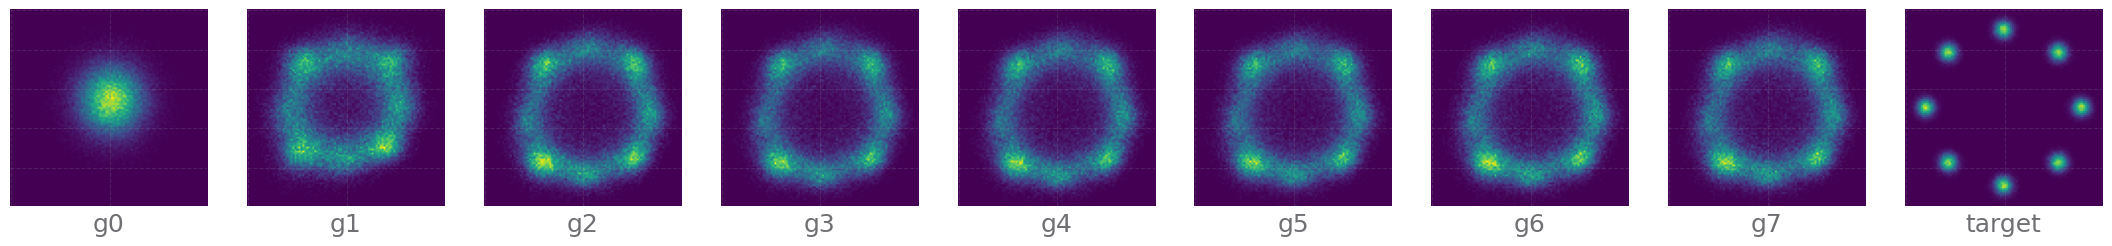

In [38]:
with pyro.plate("render", num_renderable_samples):
    chain_samples = chain()
    plot_sequence([
        (f"g{k}", chain_samples.nodes[f"g{k}"]['value'].detach()) for k in range(num_targets)
    ] + [
        ('target', target().nodes['_RETURN']['value'])
    ])